# M2 Agentic AI - Chart Generation

## 1. Introduction

### 1.1. Lab overview

In this ungraded lab, you will practice applying **reflection patterns** to enhance how agents reason and generate visualizations. You will analyze how an agent can detect issues in its own chart outputs—such as unclear labels, misleading scales, or poor aesthetics—and refine its plotting code before finalizing an answer.

### 🎯 1.2. Learning outcome

Apply reflection patterns to improve agent reasoning and chart outputs.

To achieve this, you will implement evaluation loops where an agent reviews its own (or external) generated charts, identifies potential errors or gaps, and revises its plotting code before producing the final visualization.

This process involves the following steps:

* **Generate an Initial Version (V1):**
Use a Large Language Model (LLM) to create the first version of the plotting code.

2. **Execute and Render:** 
Run the generated code and display the resulting chart.

3. **Reflect on the Output:**
Evaluate both the code and the chart using an LLM to detect areas for improvement (e.g., clarity, accuracy, design).

4. **Generate and Execute Improved Version (V2):**
Produce a refined version of the plotting code based on reflection insights and render the enhanced chart.

Through this reflective workflow, you will experience how agents can progressively improve visualization quality by combining code generation with intelligent feedback.

## 2. Setup: Initialize environment and client

In [1]:
import re
import json
import utils

### 2.1 Loading the dataset

Before writing any code, you'll preview a handful of sample rows to build intuition — this simple step often reveals the most important questions you’ll answer with a chart.

**Agentic mindset:** Explore the data → Draft a solution → Reflect and improve.

If you'd like to take a look at the data, open File > Open from the top menu.

In [2]:
# Use this utils.py function to load the data into a dataframe
df = utils.load_and_prepare_data('coffee_sales.csv')

# Grab a random sample to display
utils.print_html(df.sample(n=5), title="Random Sample of Coffee Sales Data")

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-07-03,15:24,card,ANON-0000-0000-0346,3.772,Cappuccino,3,7,2024
2024-10-17,14:09,card,ANON-0000-0000-0777,3.576,Hot Chocolate,4,10,2024
2025-01-27,12:07,card,ANON-0000-0000-1130,3.576,Latte,1,1,2025
2025-03-13,17:13,card,ANON-0000-0000-1158,3.576,Cappuccino,1,3,2025
2024-05-30,08:15,card,ANON-0000-0000-0242,3.282,Americano with Milk,2,5,2024


We are going to use this dataset to create charts as part of the agentic workflow. Let’s begin building the pipeline step by step!

## 3. Building the pipeline

### 3.1. Step 1 — Generate (V1)

**LLM Role:** _Data Visualization Expert_ using **Matplotlib** (no Seaborn)

**Task:** Write Python code that generates a chart based on user instructions and the provided schema/description

**Guardrails:**

- Assume a DataFrame named `df` already exists.
- Always include clear titles, axis labels, and legends so the chart is easy to interpret.
- Instead of displaying with `plt.show()`, save the chart image to the specified file path.

**Why Reflection?**  
Just like a human drafts a chart, reviews it, and then makes improvements, reflection allows the agent to:
* Create an initial version of the chart.
* Critically review the output (checking readability, accuracy, and style).
* Revise the code to produce a clearer, more effective visualization.

Reflection turns chart-making into an iterative process of continuous improvement, ensuring that each version is more informative and polished than the last.

In [3]:
def generate_chart_code(instruction: str, model: str, out_path_v1: str) -> str:
    """Generate Python code to make a plot with matplotlib using tag-based wrapping."""

    prompt = f"""
    You are a data visualization expert.

    Return your answer *strictly* in this format:

    <execute_python>
    # valid python code here
    </execute_python>

    Do not add explanations, only the tags and the code.

    The code should create a visualization from a DataFrame 'df' with these columns:
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    User instruction: {instruction}

    Requirements for the code:
    1. Assume the DataFrame is already loaded as 'df'.
    2. Use matplotlib for plotting.
    3. Add clear title, axis labels, and legend if needed.
    4. Save the figure as '{out_path_v1}' with dpi=300.
    5. Do not call plt.show().
    6. Close all plots with plt.close().
    7. Add all necessary import python statements

    Return ONLY the code wrapped in <execute_python> tags.
    """

    response = utils.get_response(model, prompt)
    return response

Now, try out the function and analyze the response!

In [4]:
# Generate initial code
code_v1 = generate_chart_code(
    instruction="Give me a breakdown of drink sales by quarter.", 
    model="gpt-4.1", 
    out_path_v1="chart_v1.png"
)

utils.print_html(code_v1, title="Generated Code Output (V1)")

Great! You've generated some python code to create a chart! 

### 3.2. Step 2 — Execute and Render

In this step, the `<execute_python>` tags are essential because now it’s time to run the code you generated in Step 1 and see the chart come to life.

Here's how it works:

1. **Extract the code:**  
   A regex pattern is used to grab the code that’s wrapped inside the `<execute_python>` tags.

2. **Execute the code:**
   The extracted code is run in a predefined global context where the DataFrame `df` is already available. This means your code can directly use df without needing to reload the dataset.

3. **Generate the chart::**
   If the code executes successfully, it will create a chart and save it as `chart_v1.png`.

4. **View the chart in the notebook:**
   The saved chart is then displayed inline using `utils.print_html`, making it easy for you to review the results.

By completing this step, you’ll have your first draft visualization (V1) ready — a big milestone in the reflection workflow!


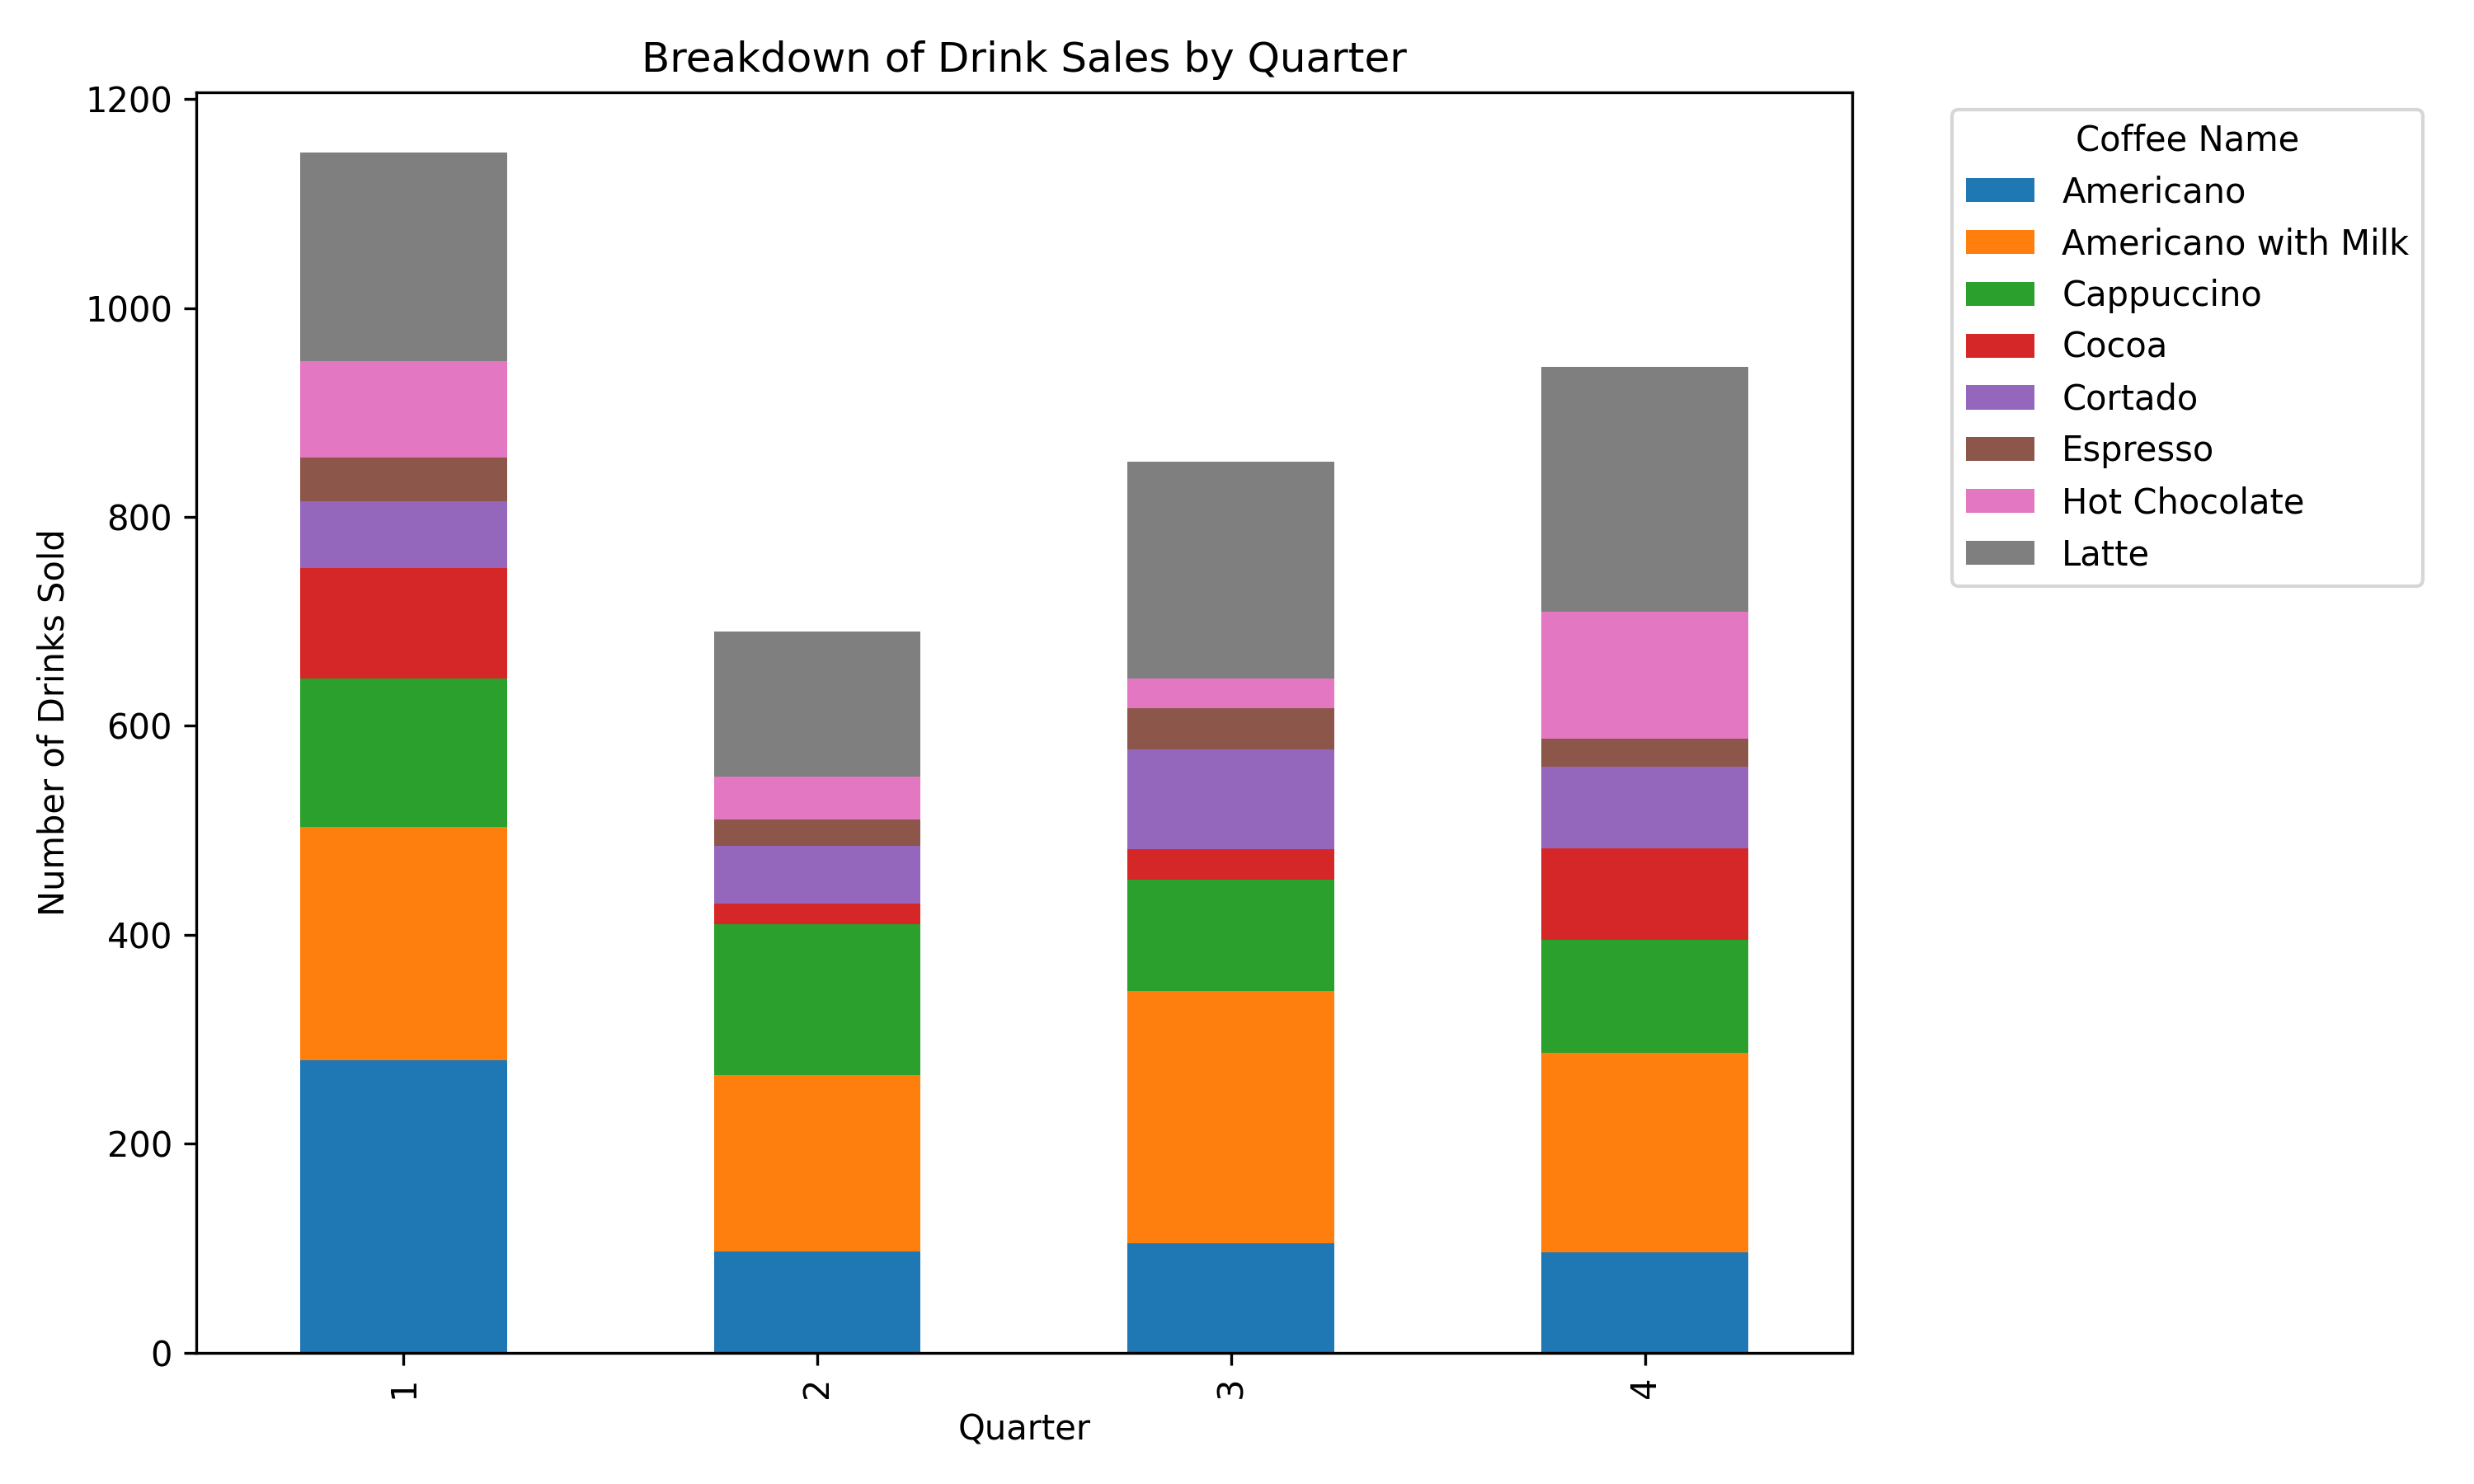

In [5]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
if match:
    initial_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(initial_code, exec_globals)

# If code run successfully, the file chart_v1.png should have been generated
utils.print_html(
    content="chart_v1.png",
    title="Generated Chart (V1)",
    is_image=True
)

### 3.3. Step 3 — Reflect on the output

The goal here is to simulate how a human would review a first draft of a chart—looking for strengths, weaknesses, and areas for improvement.

Here’s what happens:

**1. Provide the chart to the LLM:**
The generated chart (chart_v1.png) is shared with the LLM so it can “see” the visualization.

**2. Analyze the chart visually:**
The LLM reviews elements like clarity, labeling, accuracy, and overall readability.

**3. Generate feedback:**
The LLM suggests improvements—for example, fixing axis labels, adjusting the chart type, improving color choices, or highlighting missing legends.

By doing this, you create an intelligent feedback loop where the chart is not just produced once, but actively critiqued—setting the stage for a stronger second version (V2).

In [6]:
def reflect_on_image_and_regenerate(
    chart_path: str,
    instruction: str,
    model_name: str,
    out_path_v2: str,
) -> tuple[str, str]:
    """
    Critique the chart IMAGE against the instruction, then return refined matplotlib code.
    Returns (feedback, refined_code_with_tags).
    Supports OpenAI and Anthropic (Claude).
    """
    media_type, b64 = utils.encode_image_b64(chart_path)
    
    prompt = f"""
    You are a data visualization expert. First, critique how well the attached chart communicates 
    the instruction. Then return improved matplotlib code.

    STRICT OUTPUT FORMAT (JSON only):
    {{
      "feedback": "<brief, specific critique and suggestions>",
      "refined_code": "<ONLY python code, wrapped in <execute_python> tags; assumes df exists; saves to '{out_path_v2}' with dpi=300; NO plt.show(); DO call plt.close() at end>"
    }}

    Constraints for the refined code:
    - Use pandas/matplotlib only (no seaborn).
    - Assume df exists; no file reads.
    - Save to '{out_path_v2}' with dpi=300.
    - If year/month/quarter are needed and missing, derive them from df['date'] with:
      df['date'] = pd.to_datetime(df['date'], errors='coerce')
      if 'year' not in df.columns: df['year'] = df['date'].dt.year
      if 'month' not in df.columns: df['month'] = df['date'].dt.month
      if 'quarter' not in df.columns: df['quarter'] = df['date'].dt.quarter

    Schema (columns you may reference):
    - date (M/D/YY)
    - time (HH:MM)
    - cash_type (card or cash)
    - card (string)
    - price (number)
    - coffee_name (string)
    - quarter (1-4)
    - month (1-12)
    - year (YYYY)

    Add all necessary import python statements

    Instruction:
    {instruction}
    """

    lower = model_name.lower()
    if "claude" in lower or "anthropic" in lower:
        # ✅ Use the safe helper that joins all text blocks and adds a system prompt
        content = utils.image_anthropic_call(model_name, prompt, media_type, b64)
    else:
        content = utils.image_openai_call(model_name, prompt, media_type, b64)

    # Robust JSON parse
    try:
        obj = json.loads(content)
    except Exception:
        m = re.search(r"\{.*\}", content, flags=re.DOTALL)
        obj = json.loads(m.group(0)) if m else {"feedback": content, "refined_code": ""}

    feedback = str(obj.get("feedback", "")).strip()
    refined_code = utils.ensure_execute_python_tags(str(obj.get("refined_code", "")).strip())
    return feedback, refined_code


### 3.4. Step 4 — Generate and Execute Improved Version (V2)

Final step, it is time to generate and run the new version(v2).

In [7]:
# Generate feedback alongside reflected code
feedback, code_v2 = reflect_on_image_and_regenerate(
    chart_path="chart_v1.png",            
    instruction="Give me a breakdown of drink sales by quarter.",                   
    model_name="o4-mini",
    out_path_v2="chart_v2.png"             
)

utils.print_html(feedback, title="Feedback on V1 Chart")
utils.print_html(code_v2, title="Regenerated Code Output (V2)")


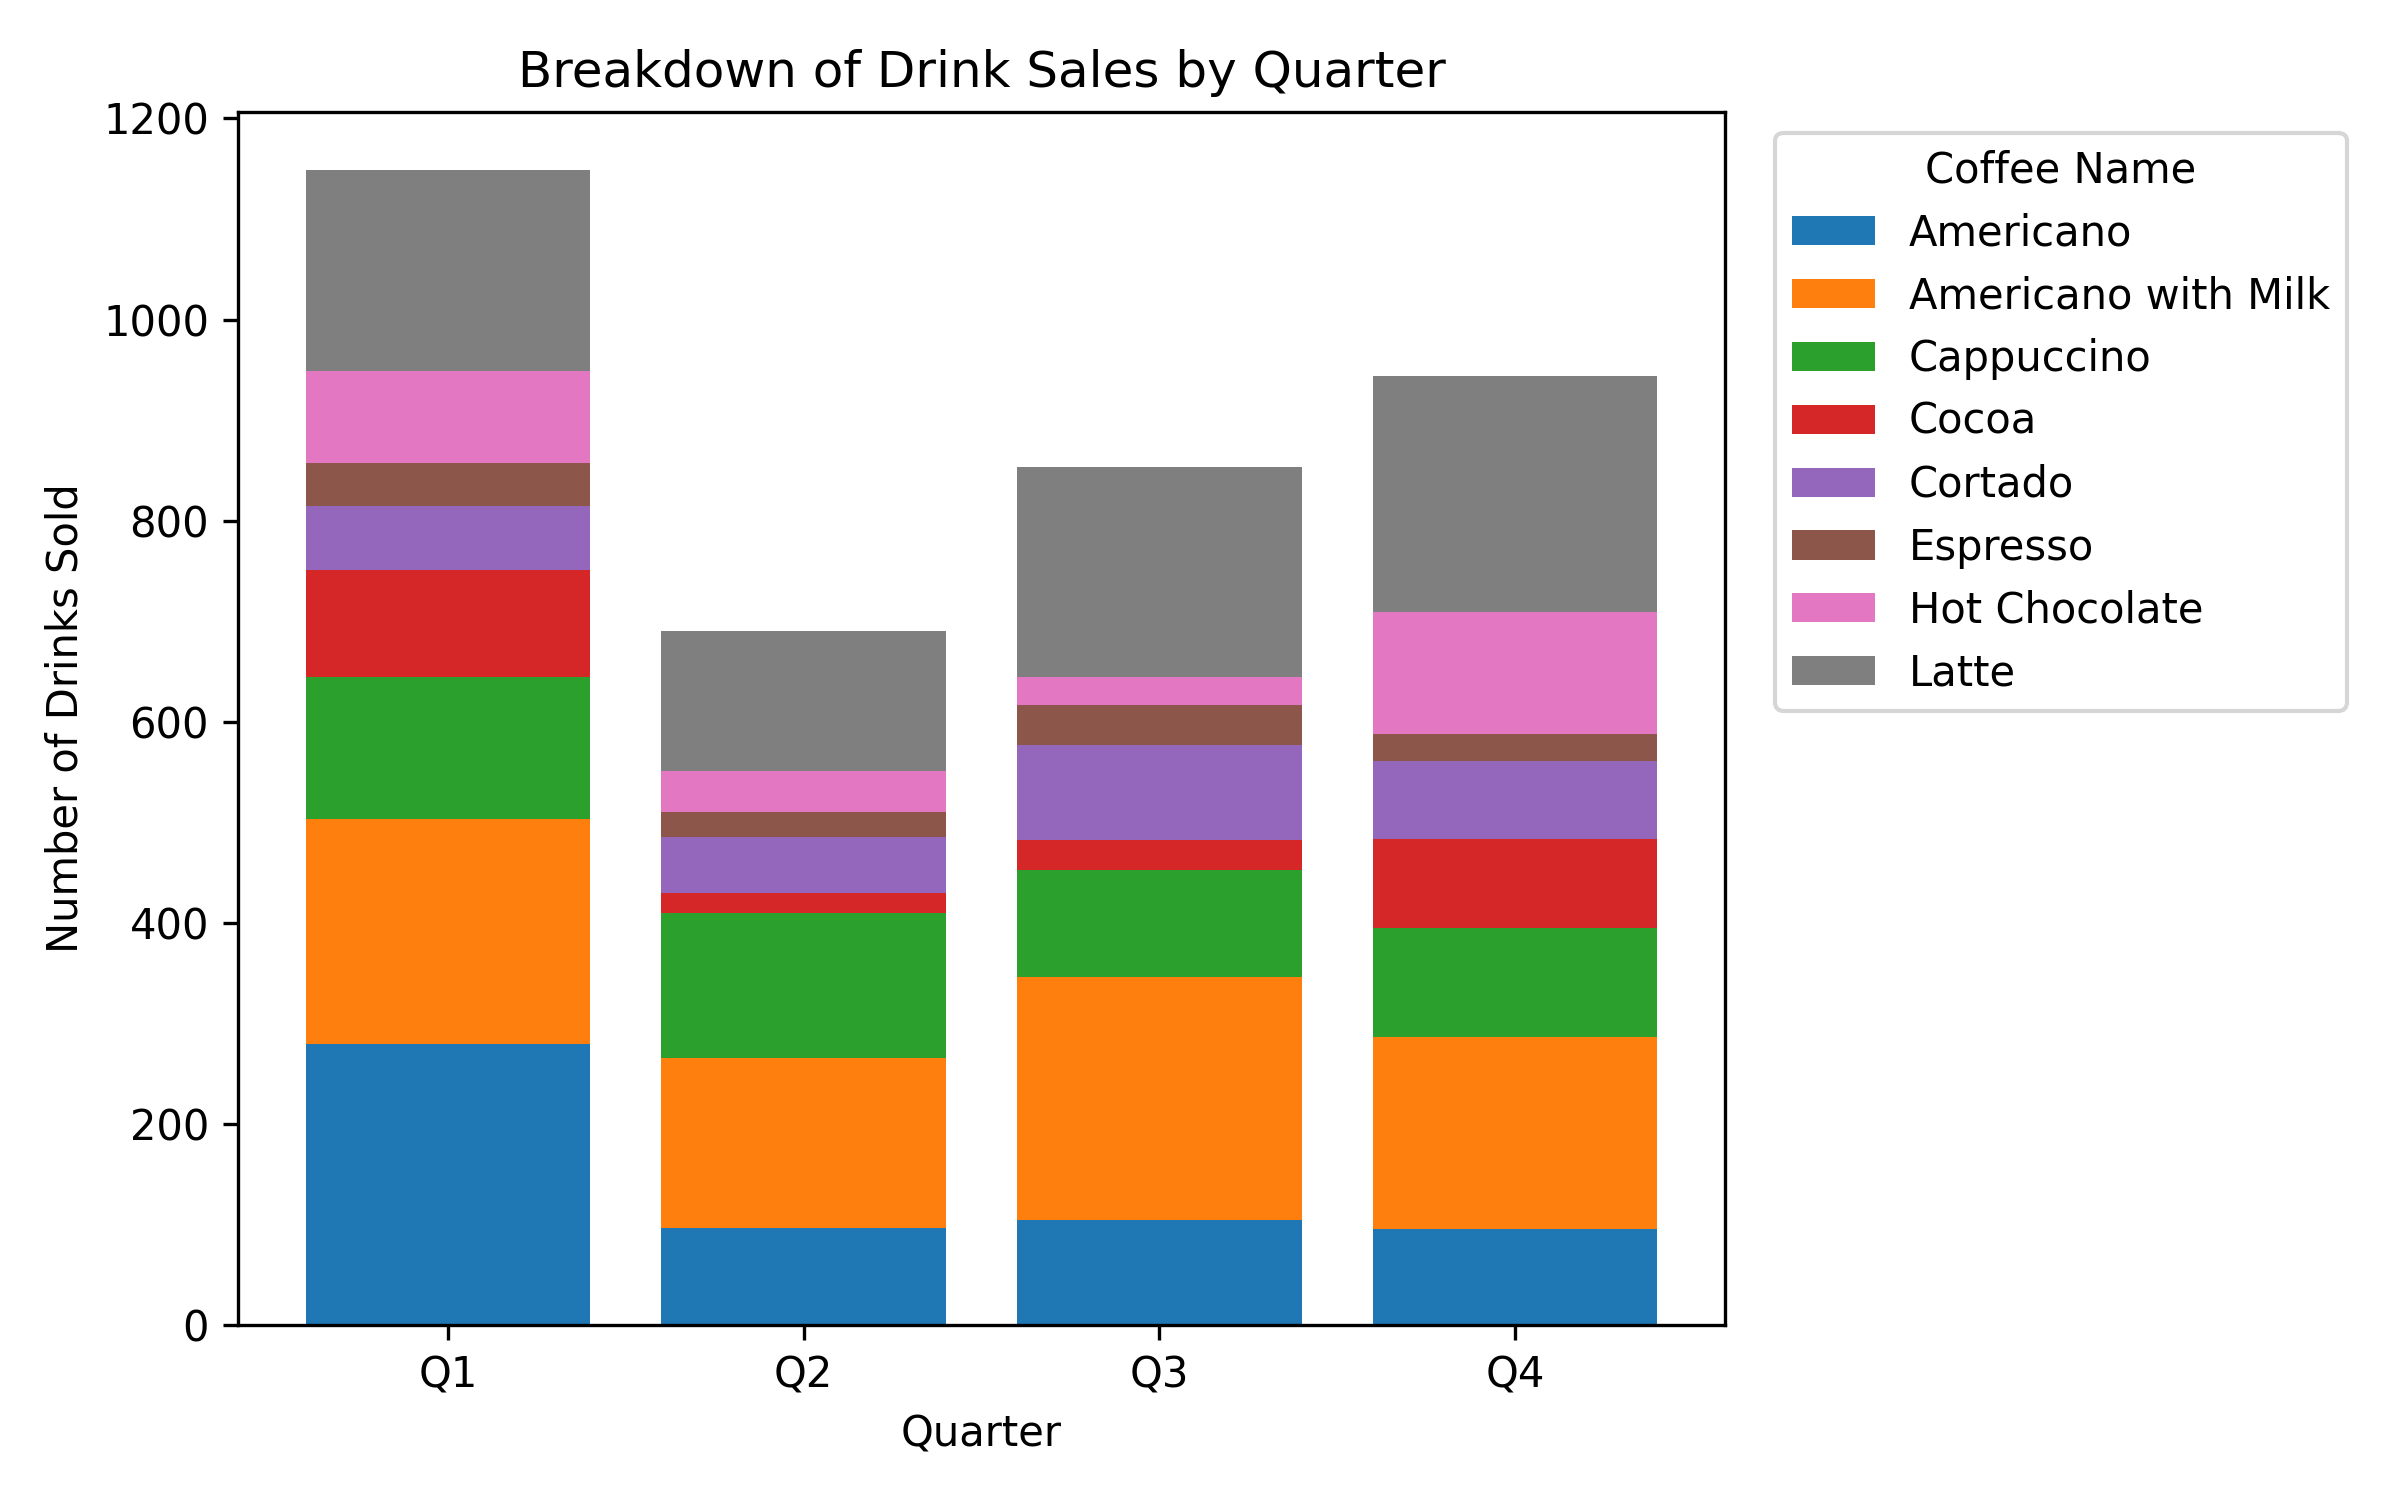

In [8]:
# Get the code within the <execute_python> tags
match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
if match:
    reflected_code = match.group(1).strip()
    exec_globals = {"df": df}
    exec(reflected_code, exec_globals)

# If code run successfully, the file chart_v2.png should have been generated
utils.print_html(
    content="chart_v2.png",
    title="Regenerated Chart (V2)",
    is_image=True
)

### 4. Your end-to-end chart generation workflow

Now it’s time to wrap up into a single automated workflow that the agent can run from start to finish.

In the `run_workflow` function, you will:

* Provide the chart instructions: Define what kind of chart you want to create and what insights it should show.
* Choose the models for each step: Specify which LLMs handle generation, reflection, and refinement.

This setup gives you the freedom to mix and match different models at various stages of the workflow. By experimenting, you’ll discover which combinations work best for generating accurate, clear, and polished charts.

In [9]:
def run_workflow(
    dataset_path: str,
    user_instructions: str,
    generation_model: str,
    evaluation_model: str,
    image_basename: str = "chart",
):
    """
    End-to-end pipeline: generate -> execute -> (evaluate + refine) -> execute refined.
    Returns a dict with all artifacts (codes, feedback, images).
    """
    # Load dataset (LLM handles derivations like year/quarter)
    df = utils.load_and_prepare_data(dataset_path)
    utils.print_html(df.sample(n=5), title="Random Sample of Dataset")

    # Paths to store charts
    out_v1 = f"{image_basename}_v1.png"
    out_v2 = f"{image_basename}_v2.png"

    # Step 1: Generate code V1
    utils.print_html("Step 1: Generating chart code... 📈\n")
    code_v1 = generate_chart_code(
        instruction=user_instructions,
        model=generation_model,
        out_path_v1=out_v1,
    )
    utils.print_html(code_v1, title="Generated Code Output (V1)")

    # Step 2: Execute V1
    utils.print_html("Step 2: Executing chart code... 💻\n")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v1)
    if match:
        initial_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(initial_code, exec_globals)

    utils.print_html(out_v1, is_image=True, title="Generated Chart (V1)")

    # Step 3: Evaluate + refine
    utils.print_html("Step 3: Evaluating and refining chart... 🔁\n")
    feedback, code_v2 = reflect_on_image_and_regenerate(
        chart_path=out_v1,
        instruction=user_instructions,
        model_name=evaluation_model,
        out_path_v2=out_v2,
    )
    utils.print_html(feedback, title="Feedback on V1 Chart")
    utils.print_html(code_v2, title="Regenerated Code Output (V2)")

    # Step 4: Execute V2
    utils.print_html("Step 4: Executing refined chart code... 🖼️\n")
    match = re.search(r"<execute_python>([\s\S]*?)</execute_python>", code_v2)
    if match:
        reflected_code = match.group(1).strip()
        exec_globals = {"df": df}
        exec(reflected_code, exec_globals)

    utils.print_html(out_v2, is_image=True, title="Regenerated Chart (V2)")

### 4.1. Using the workflow with updated instructions

Let’s update our workflow to try a new example.

- **Previous instruction:** “Give me a breakdown of drink sales by quarter.”
- **New instruction:** "Create a chart showing year-over-year Q1 sales by drink type."

### Customizing instructions

You’re encouraged to experiment with your own chart prompts!
When you change the instructions, remember to also update the `image_basename` parameter. This helps keep your saved chart files organized and ensures their filenames reflect the content.

By customizing both the instructions and filenames, you can adapt the workflow to many different analyses while keeping your results neat and easy to track.

### Available models for generation and evaluation

Your workflow lets you choose which models handle chart generation and which handle evaluation. Here are the options:

#### Generation models

- **gpt-3.5-turbo** – Reliable and versatile for many tasks.
- **gpt-4.1-mini** – A lighter version of GPT-4.1, optimized for speed.
- **gpt-4.1** – Full-featured GPT-4.1 with strong reasoning capabilities.
- **gpt-4o-mini** – Compact and fast, good for quicker experimentation.

#### Evaluation models

- **o4-mini** – Lightweight and efficient for evaluation.
- **claude-3-5-haiku-20241022** – Specialized for concise, precise feedback.
- **claude-3-7-sonnet-20250219** – Advanced evaluation model with deeper analysis.

Additionally, any of the generation models can also be used for evaluation. This flexibility lets you try different combinations and see how they impact the quality of your charts.

Experiment with these models to find different scenarios!

**Important note on LLM responses:** LLM outputs are stochastic — meaning that even with the same input and parameters, results can vary each time you run the workflow. This randomness is a feature, not a bug: it allows you to explore multiple possible solutions. For more reliable insights, try running your workflow several times and comparing results.

date,time,cash_type,card,price,coffee_name,quarter,month,year
2024-09-23,16:30,card,ANON-0000-0000-0507,3.282,Latte,3,9,2024
2025-03-19,06:01,card,ANON-0000-0000-1152,2.596,Americano,1,3,2025
2024-09-14,15:57,card,ANON-0000-0000-0543,3.282,Cappuccino,3,9,2024
2024-07-18,10:08,card,ANON-0000-0000-0375,3.282,Latte,3,7,2024
2024-11-09,07:23,card,ANON-0000-0000-0141,2.596,Cortado,4,11,2024



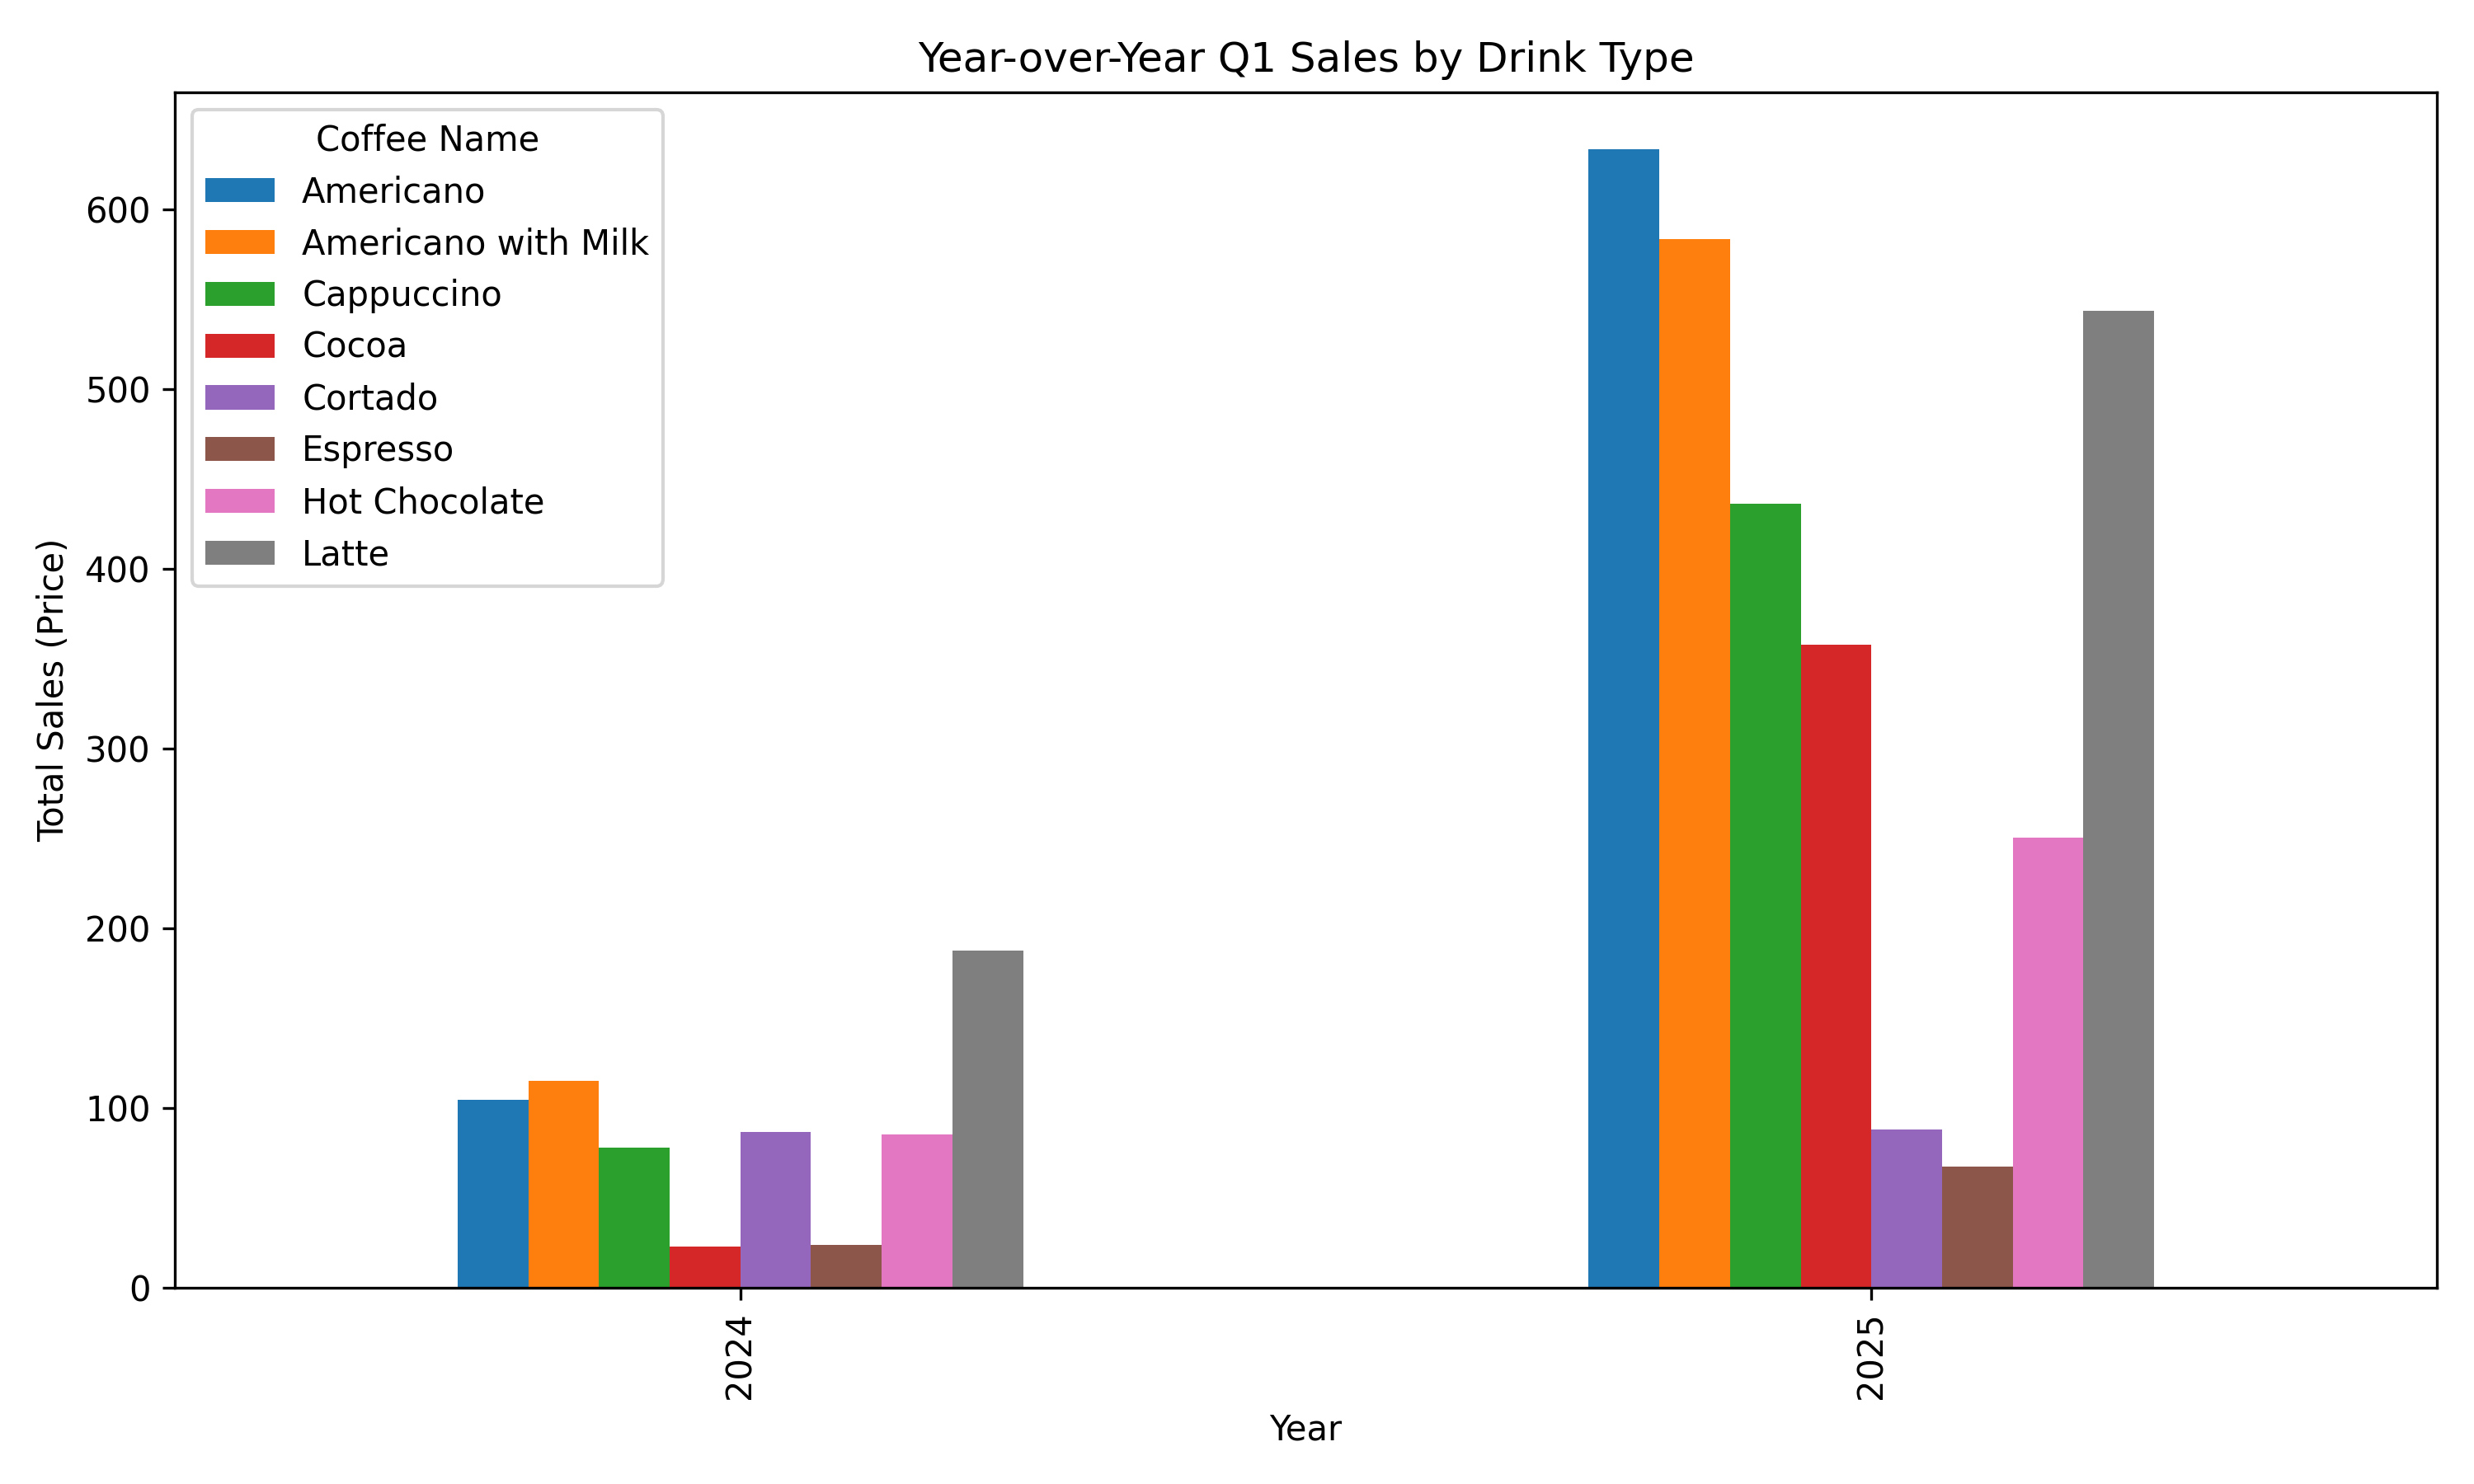


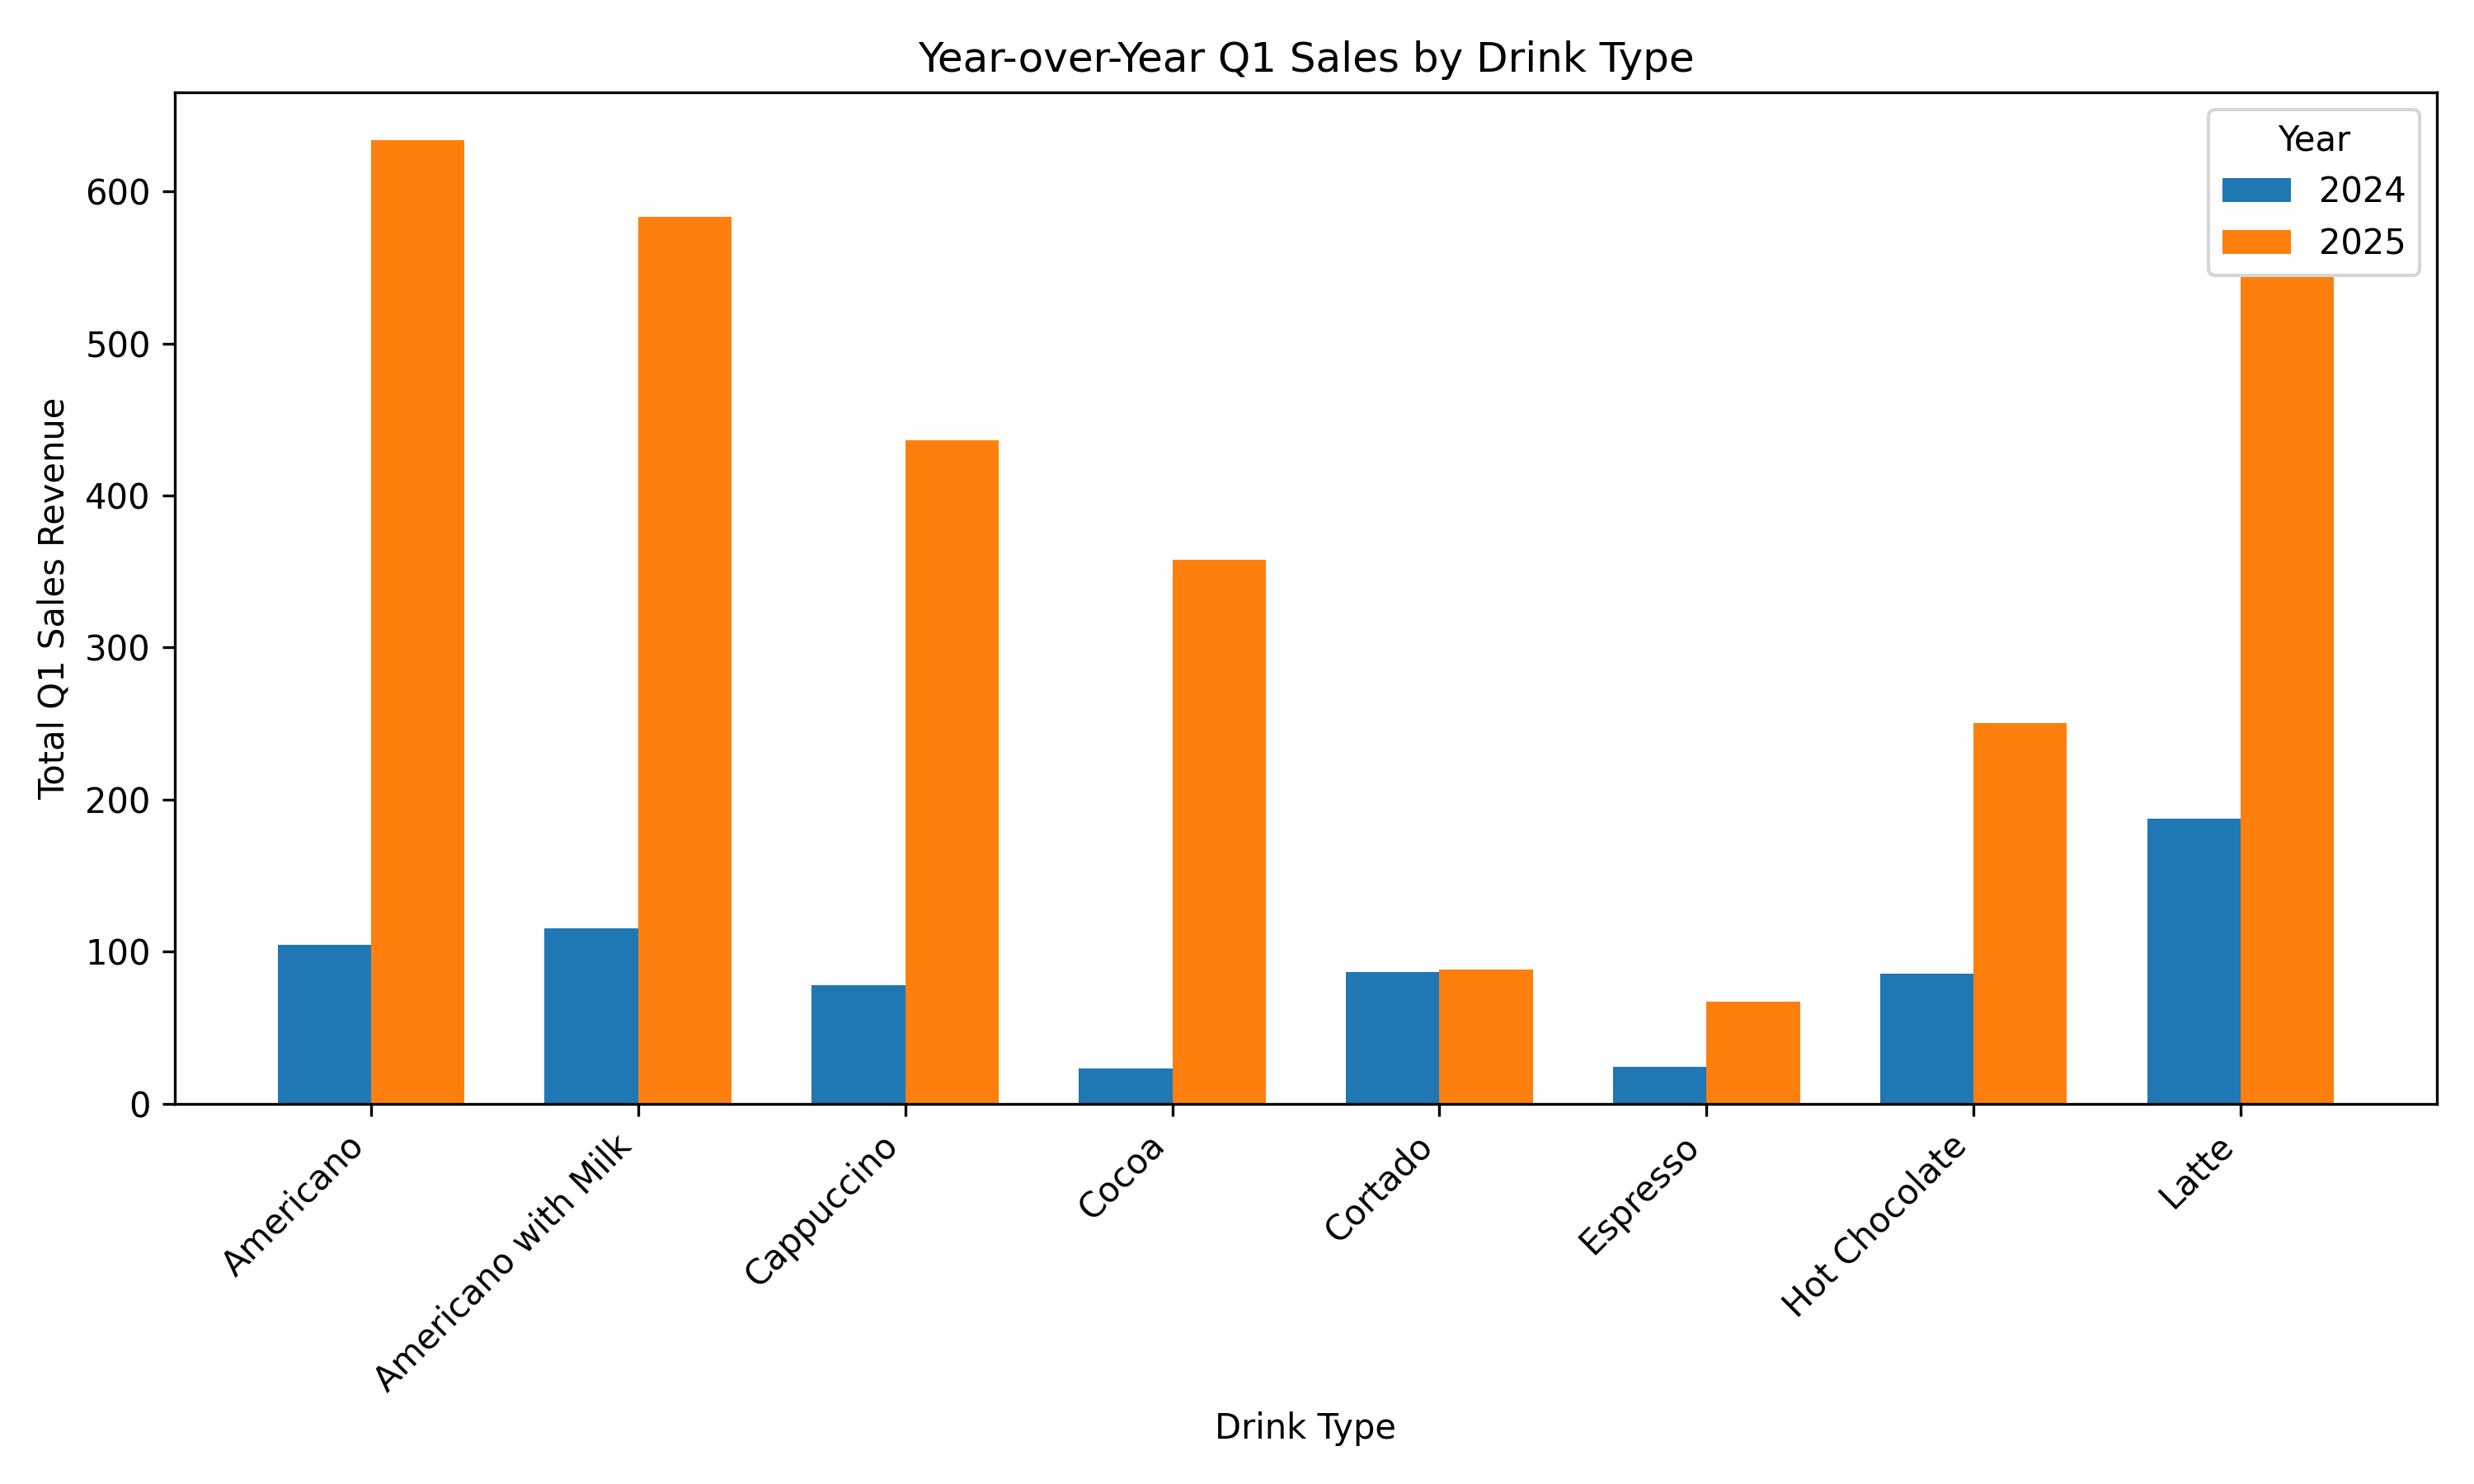

In [10]:
# Here, insert your updates
user_instructions="Create a chart showing year-over-year Q1 sales by drink type."
generation_model="gpt-4.1"
evaluation_model="o4-mini"
image_basename="drink_sales"

# Run the complete agentic workflow
run_workflow(
    dataset_path="coffee_sales.csv",
    user_instructions=user_instructions,
    generation_model=generation_model,
    evaluation_model=evaluation_model,
    image_basename=image_basename
)

## 5. Final Takeaways

In this lab, **you** practiced using reflection to improve chart outputs.
You learned to:

* Generate an initial chart (V1).
* Critique and refine it into a better version (V2).
* Automate the full workflow with different models.

The key idea: reflection helps **you** create clearer, more accurate, and more effective visualizations.


<div style="border:1px solid #22c55e; border-left:6px solid #16a34a; background:#dcfce7; border-radius:6px; padding:14px 16px; color:#064e3b; font-family:system-ui,-apple-system,Segoe UI,Roboto,Ubuntu,Cantarell,Noto Sans,sans-serif;">

🎉 <strong>Congratulations!</strong>  

You’ve completed the lab on building an **agentic chart generation workflow**.  
Along the way, **you** practiced generating charts, reflecting on their quality, and refining them into clearer and more effective visualizations.  

With these skills, **you** are ready to design agentic pipelines that create data visualizations automatically while keeping them accurate, explainable, and polished. 🌟  

</div>

